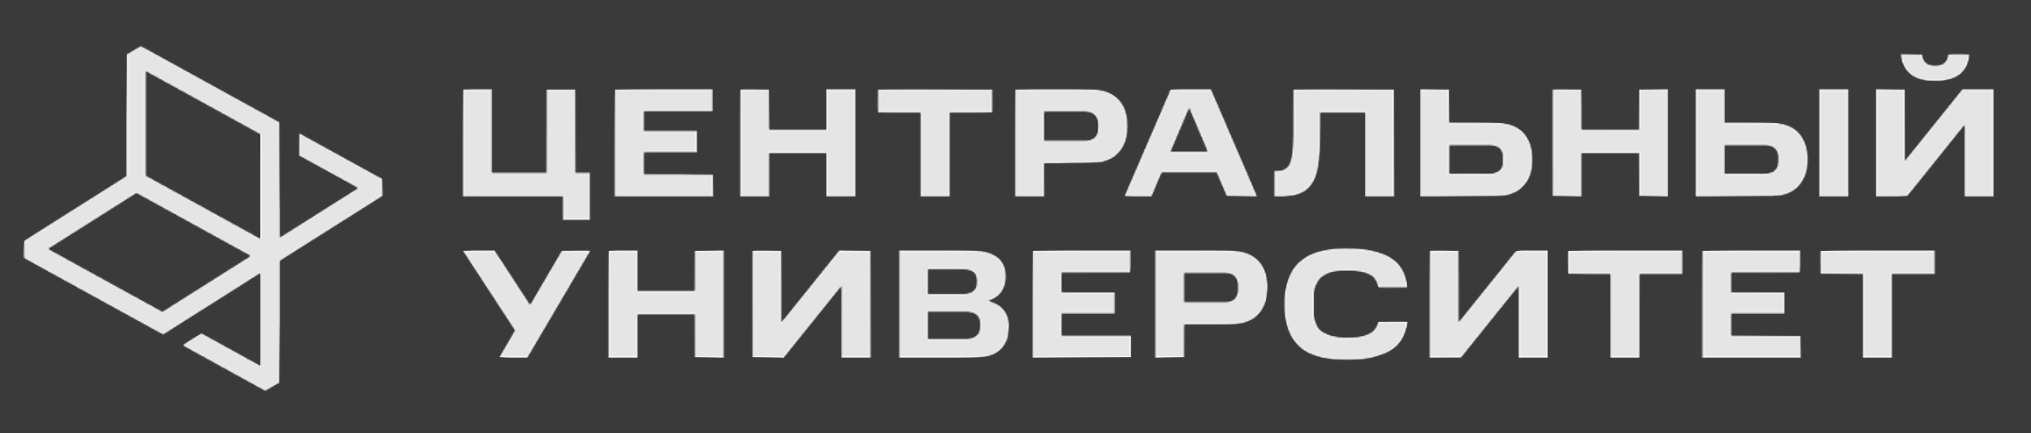

# Курс по глубокому обучению

## Домашнее задание 5. Сверточные нейронные сети (10 баллов + 2 балла)

# О формате сдачи

🔷 **<font color='plum'>При решении ноутбука используйте данный шаблон</font>**

    ✅ Можно добавлять новые ячейки любых типов
    ❌ Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий


🔷 **<font color='plum'>При оценивании задач учитывается код</font>**

    ✅ Задания, в которых необходим код, обычно помечаются фразами "Your code here"/"Ваш код" и аналогичными
    ❌ Ответы на вопросы без сопутствующего кода оцениваются в 0 баллов
    ❌ Наличе работоспособного кода в ноутбуке, если на сказано иного, обязательно

🔷 **<font color='plum'>При оценивании задач учитываются выводы</font>**

    ✅ Задания, в которых необходимы выводы, обычно помечаются фразами Вывод"/"Ответ на вопрос"/"Ваш текст" и аналогичными
    ✅ Обычно выводы подразумевают под собой текстовый ответ (можно писать markdown, latex).
    ✅ Сопутствующие изображения, графики, таблички - приветствуются!
    ❌ При отсутствии выводов задание не засчитается на полный балл

## О задании

В этом задании вы поработаете с датасетом фотографий разных видов спорта, решите задачу многоклассовой классификации для достаточно большого вида классов, используете новые виды аугментации картинок и самостоятельно реализуете ResNet.

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Баллы даются за выполнение отдельных пунктов. Задачи рекомендуется решать в том порядке, в котором они даны в задании.


--------

# Задание

Хорошим тоном при написании моделей является фиксировать seed (некоторый параметр, от которого зависит результат работы рандомизированных алгоритмов), чтобы результаты обучения были воспроизводимы. Давайте и мы зафиксируем seed

In [ ]:
import PIL
import torchvision
from PIL import Image
from torchvision.transforms import v2
import pandas as pd
import numpy as np
import random
import torch
import os
from tqdm.auto import tqdm

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


В этот раз будем работать с датасетом фотографий разных видов спорта. Он уже за нас разделен train/val/test. Давайте скачаем его

In [ ]:
!pip install gdown > /dev/null
!gdown https://drive.google.com/uc?id=1biITy7cv0-lo-bwZrFkyDCGsEOWCBx5W
!unzip -n sports.zip > /dev/null

Downloading...
From (original): https://drive.google.com/uc?id=1biITy7cv0-lo-bwZrFkyDCGsEOWCBx5W
From (redirected): https://drive.google.com/uc?id=1biITy7cv0-lo-bwZrFkyDCGsEOWCBx5W&confirm=t&uuid=8308428c-7dc8-4273-b6cd-5fc133455d2a
To: /content/sports.zip
100% 445M/445M [00:06<00:00, 71.2MB/s]


## <font color='DarkOrange'> **Задание 1 [1 балл]** </font>


Описание фотографий лежит в файле `sports.csv`. Давайте откроем файл в виде pandas датафрейма и посмотрим на примеры фото

In [ ]:
df = pd.read_csv('/content/sports.csv')
df.head(10)

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train
5,0,train/air hockey/006.jpg,air hockey,train
6,0,train/air hockey/007.jpg,air hockey,train
7,0,train/air hockey/008.jpg,air hockey,train
8,0,train/air hockey/009.jpg,air hockey,train
9,0,train/air hockey/010.jpg,air hockey,train


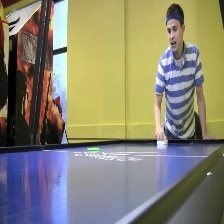

In [ ]:
img_example = Image.open(df['filepaths'][0])
img_example

Давайте посмотрим, сколько различных видов спорта есть в датасете, чтобы понять, на сколько классов будем обучать модель

In [ ]:
#YOUR CODE HERE
print(list(df['labels'].unique()))
print(len(list(df['labels'].unique())))

['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'rock climbing', 'roller 

Теперь выделим train/test части и сохраним картинки и таргет в виде списка, который будем потом запихивать в даталоадер.

In [ ]:
train_df = df[df['data set']=='train']
test_df = df[df['data set']=='test']

Исходный датасет достаточно большой, и так как ресурсы колаба ограничены, давайте поработаем только с первыми 30 классами.


<font color='LightSteelBlue'>**Подсказка**</font> Все картинки одинакового размера, дополнительно это проверять не нужно

In [ ]:
train_images = []
test_images = []

for _, row in (train_df.iterrows()):
  target = row['class id']
  path = row['filepaths']
  if path.endswith('jpg') and target <= 29:
    img = Image.open(path)
    train_images.append((img, target))

for _, row in (test_df.iterrows()):
  target = row['class id']
  path = row['filepaths']
  if path.endswith('jpg') and target <= 29:
    img = Image.open(path)
    test_images.append((img, target))

random.shuffle(train_images)
random.shuffle(test_images)

## <font color='DarkOrange'> **Задание 2 [3 баллa]** </font>


В данном задании предлагаем вам самостоятельно изучить и воспользоваться новыми видами аугментации: `RandomVerticalFlip`, `ElasticTransform`, `ChannelPermutation`.


<font color='LightSteelBlue'>**Подсказка**</font> Не стесняйтесь искать в документациях, что делает каждый метод и как его использовать. Параметры у данных методов используйте те, которые вам кажутся логичными

In [ ]:
from torch.utils.data import Dataset, DataLoader

class SportDataset(Dataset):
    def __init__(self, source, is_train=True):
        self.is_train = is_train
        self.basic_transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
        ])
        self.aug_transform = v2.Compose([
            v2.RandomVerticalFlip(p=0.5), # Переворот по вертикали с вероятностью 50%
            v2.ElasticTransform(alpha=77, sigma=7), # Эластичная трансформация
            v2.RandomChannelPermutation() # Перестановка каналов с вероятностью 50%
        ])
        self.normalize = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        data, target = list(zip(*source))
        self.data = list(map(self.basic_transform, data))
        self.target = torch.tensor(target)

    def __getitem__(self, index):
        image, label = self.data[index], self.target[index]
        if self.is_train and torch.rand(1) > 0.5:
            image = self.aug_transform(image)
        image = self.normalize(image)
        return image, label

    def __len__(self):
        return len(self.data)

In [ ]:
dataset_train = SportDataset(train_images, is_train=True)
dataset_test = SportDataset(test_images, is_train=False)

dataloader_train = DataLoader(
    dataset=dataset_train,
    batch_size=64,
    shuffle=True,
)
dataloader_test = DataLoader(
    dataset=dataset_test,
    batch_size=512,
    shuffle=True,
)

Здесь также приведем код, который может помочь при обучении нейросети

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def show_loss(iter_list, train_loss_list, test_loss_list, test_accuracy_list):
    clear_output(wait=True)

    fig, ax = plt.subplots(1, 3, figsize=(16, 5))

    ax[0].plot(iter_list[1:], train_loss_list[1:])
    ax[1].plot(iter_list, test_loss_list)
    ax[2].plot(iter_list, test_accuracy_list)

    ax[0].set_title('Train Loss')
    ax[1].set_title('Test Loss')
    ax[2].set_title('Test Accuracy')
    plt.show()

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def calc_accuracy(model, dataloader):
    y_pred = []
    y_test = []
    loss_sum = 0
    with torch.no_grad():
        for X, target in dataloader:
            X = X.cuda() #Когда отработает на CPU
            target = target.cuda() #Когда отработает на CPU
            logits = model(X)
            loss_sum += loss_fn(logits, target)
            y_pred.append(logits.argmax(dim=1))
            y_test.append(target)
        y_pred = torch.cat(y_pred)
        y_test = torch.cat(y_test)
    accuracy = torch.sum((y_pred == y_test)) / len(y_test)
    return accuracy.cpu(), loss_sum.item(), y_pred, y_test

## <font color='DarkOrange'> **Задание 3 [4 баллa]** </font>


Теперь вам предлагается реализовать архитектуру `ResNet18`

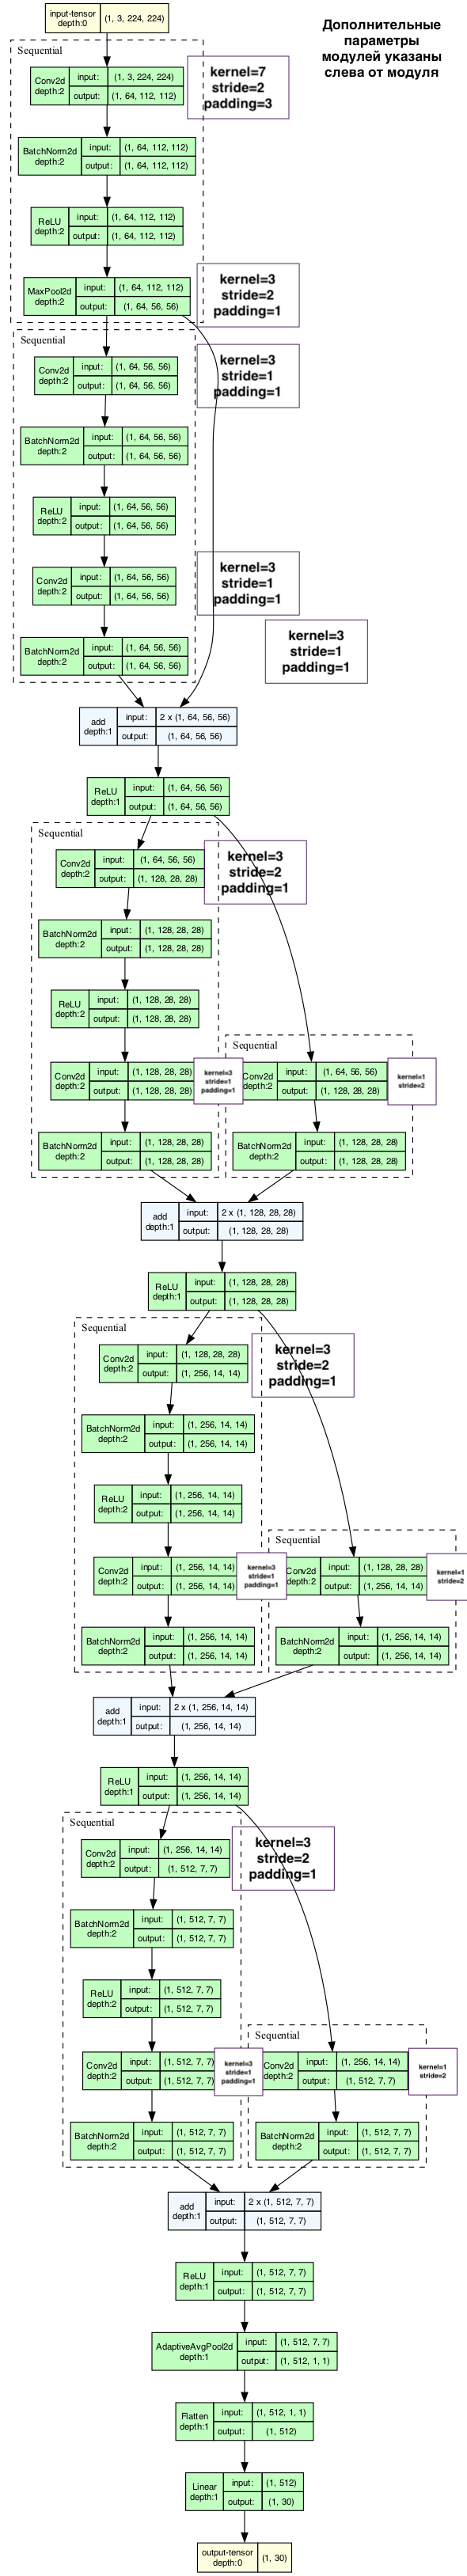

В случае, если по архитектуре выше будет неясно, какие параметры слоев, то прикрепляю еще следующий скриншот.


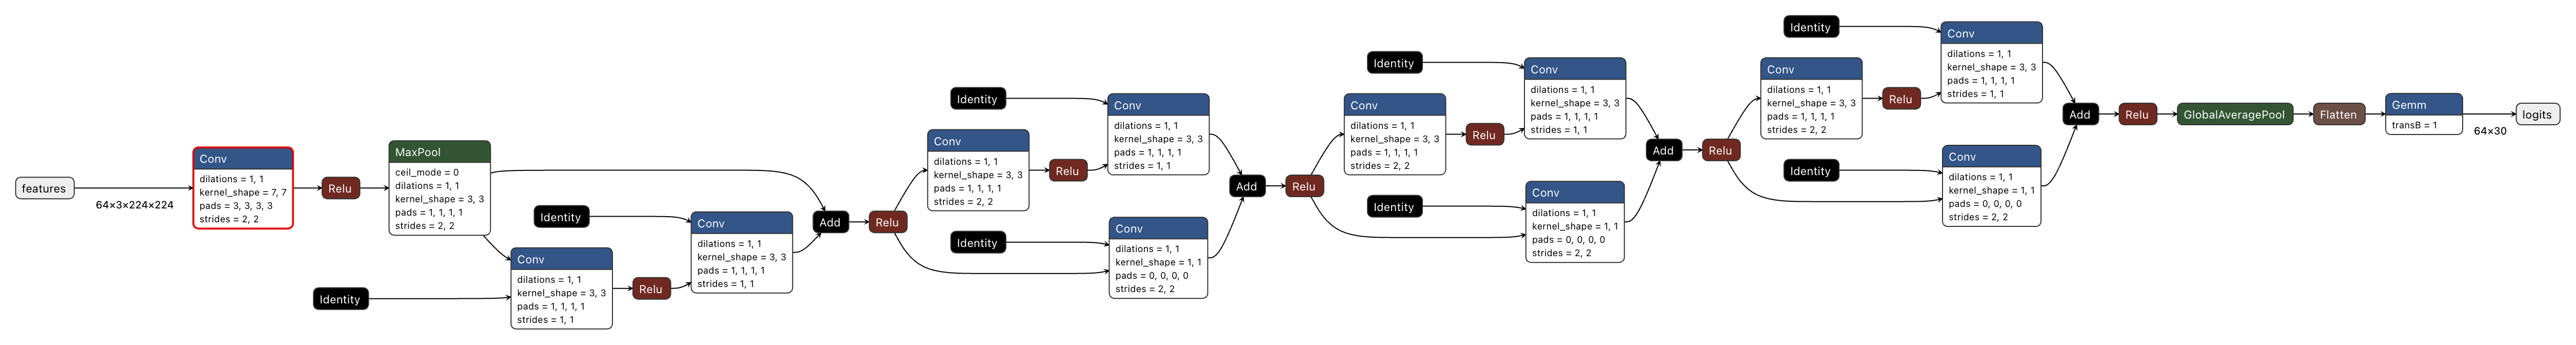

<font color='OrangeRed'>**Обратите внимание!**</font> Все сверточные слои обучаются с параметром `bias=False`


<font color='LightSteelBlue'>**Подсказка**</font> Для блока `GlobalAveragePooling` используйте модуль `nn.AdaptiveAvgPool2d((1, 1))`

In [ ]:
import torch.nn.functional as F
from torch import nn

torch.autograd.set_detect_anomaly(False)


class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.relu_last = nn.ReLU(inplace=False)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 30)

    def _make_layer(self, in_planes, planes, blocks, stride=1):
        layers = []
        layers.append(BasicBlock(in_planes, planes, stride))
        for _ in range(1, blocks):
            layers.append(BasicBlock(planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.relu_last(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inplanes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

## <font color='DarkOrange'> **Задание 4 [2 баллa]** </font>


Запустите процесс обучения и выбейте качество не менее 0.8 `Accuracy`

<font color='OrangeRed'>**Внимание!**</font> Перед запуском обучения на GPU убедитесь, что ваш код отрабатывает хотя бы несколько эпох на CPU. Только затем переходите на GPU!

<font color='OrangeRed'>**Внимание!**</font> Обучение уже может быть не мгновенным, поэтому при желании можете добавить в код обучения периодическое сохранение обученной модели. Также не воспрещается менять код обучения любым удобным для вас способом или использовать реализации с прошлых семинаров и домашних заданий

In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR
from torch import nn


n_epoch = 10

model = ResNet18().cuda() #Когда отработает на CPU
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3) #YOUR CODE HERE
scheduler = MultiStepLR(optimizer, milestones=[5, 8], gamma=0.1) #YOUR CODE HERE

In [ ]:
optimizer = Adam(model.parameters(), lr=5e-5)
scheduler = MultiStepLR(optimizer, milestones=[1, 3, 5], gamma=0.5)

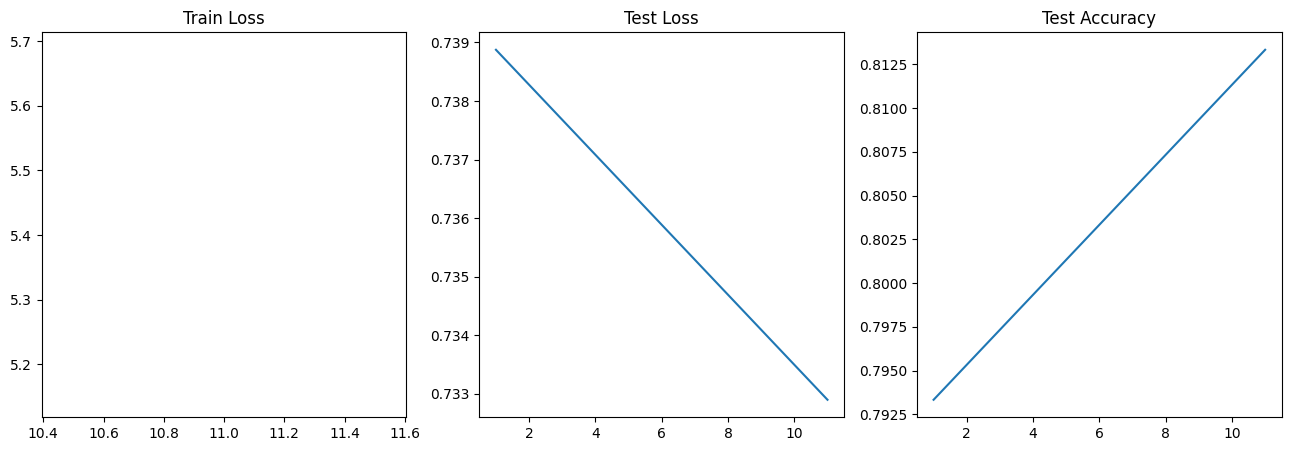


epoch: 0
loss train: 5.415933012962341
loss test: 0.7328996062278748
lr: 5e-05


In [ ]:
cur_iter = 0
iter_list = []
test_accuracy_list = []
test_loss_list = []
train_loss_list = []
for epoch in range(n_epoch):
    loss_train = 0
    if accuracy.item() > 0.8:
        break
    for X, target in tqdm(dataloader_train, ncols=80):
        if accuracy.item() > 0.8:
            break
        cur_iter += 1
        X = X.cuda() #Когда отработает на CPU
        target = target.cuda() #Когда отработает на CPU
        optimizer.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, target)
        loss.backward()
        optimizer.step()

        loss_train += loss.item()

        if cur_iter % 10 == 1:
            accuracy, loss_test, _, _ = calc_accuracy(model, dataloader_test)
            iter_list.append(cur_iter)

            test_accuracy_list.append(accuracy)
            test_loss_list.append(loss_test)
            train_loss_list.append(loss_train)

            show_loss(iter_list, train_loss_list, test_loss_list, test_accuracy_list)

            print('\nepoch:', epoch)
            print('loss train:', loss_train)
            print('loss test:', loss_test)
            print('lr:', get_lr(optimizer))

            loss_train = 0

    scheduler.step()

In [ ]:
accuracy, _, y_pred, y_test = calc_accuracy(model, dataloader_test)

assert accuracy.item() > 0.8, ':('
print('Отлично!')

Отлично!


несколько раз обучение слетало, благо модель при это сохранялась

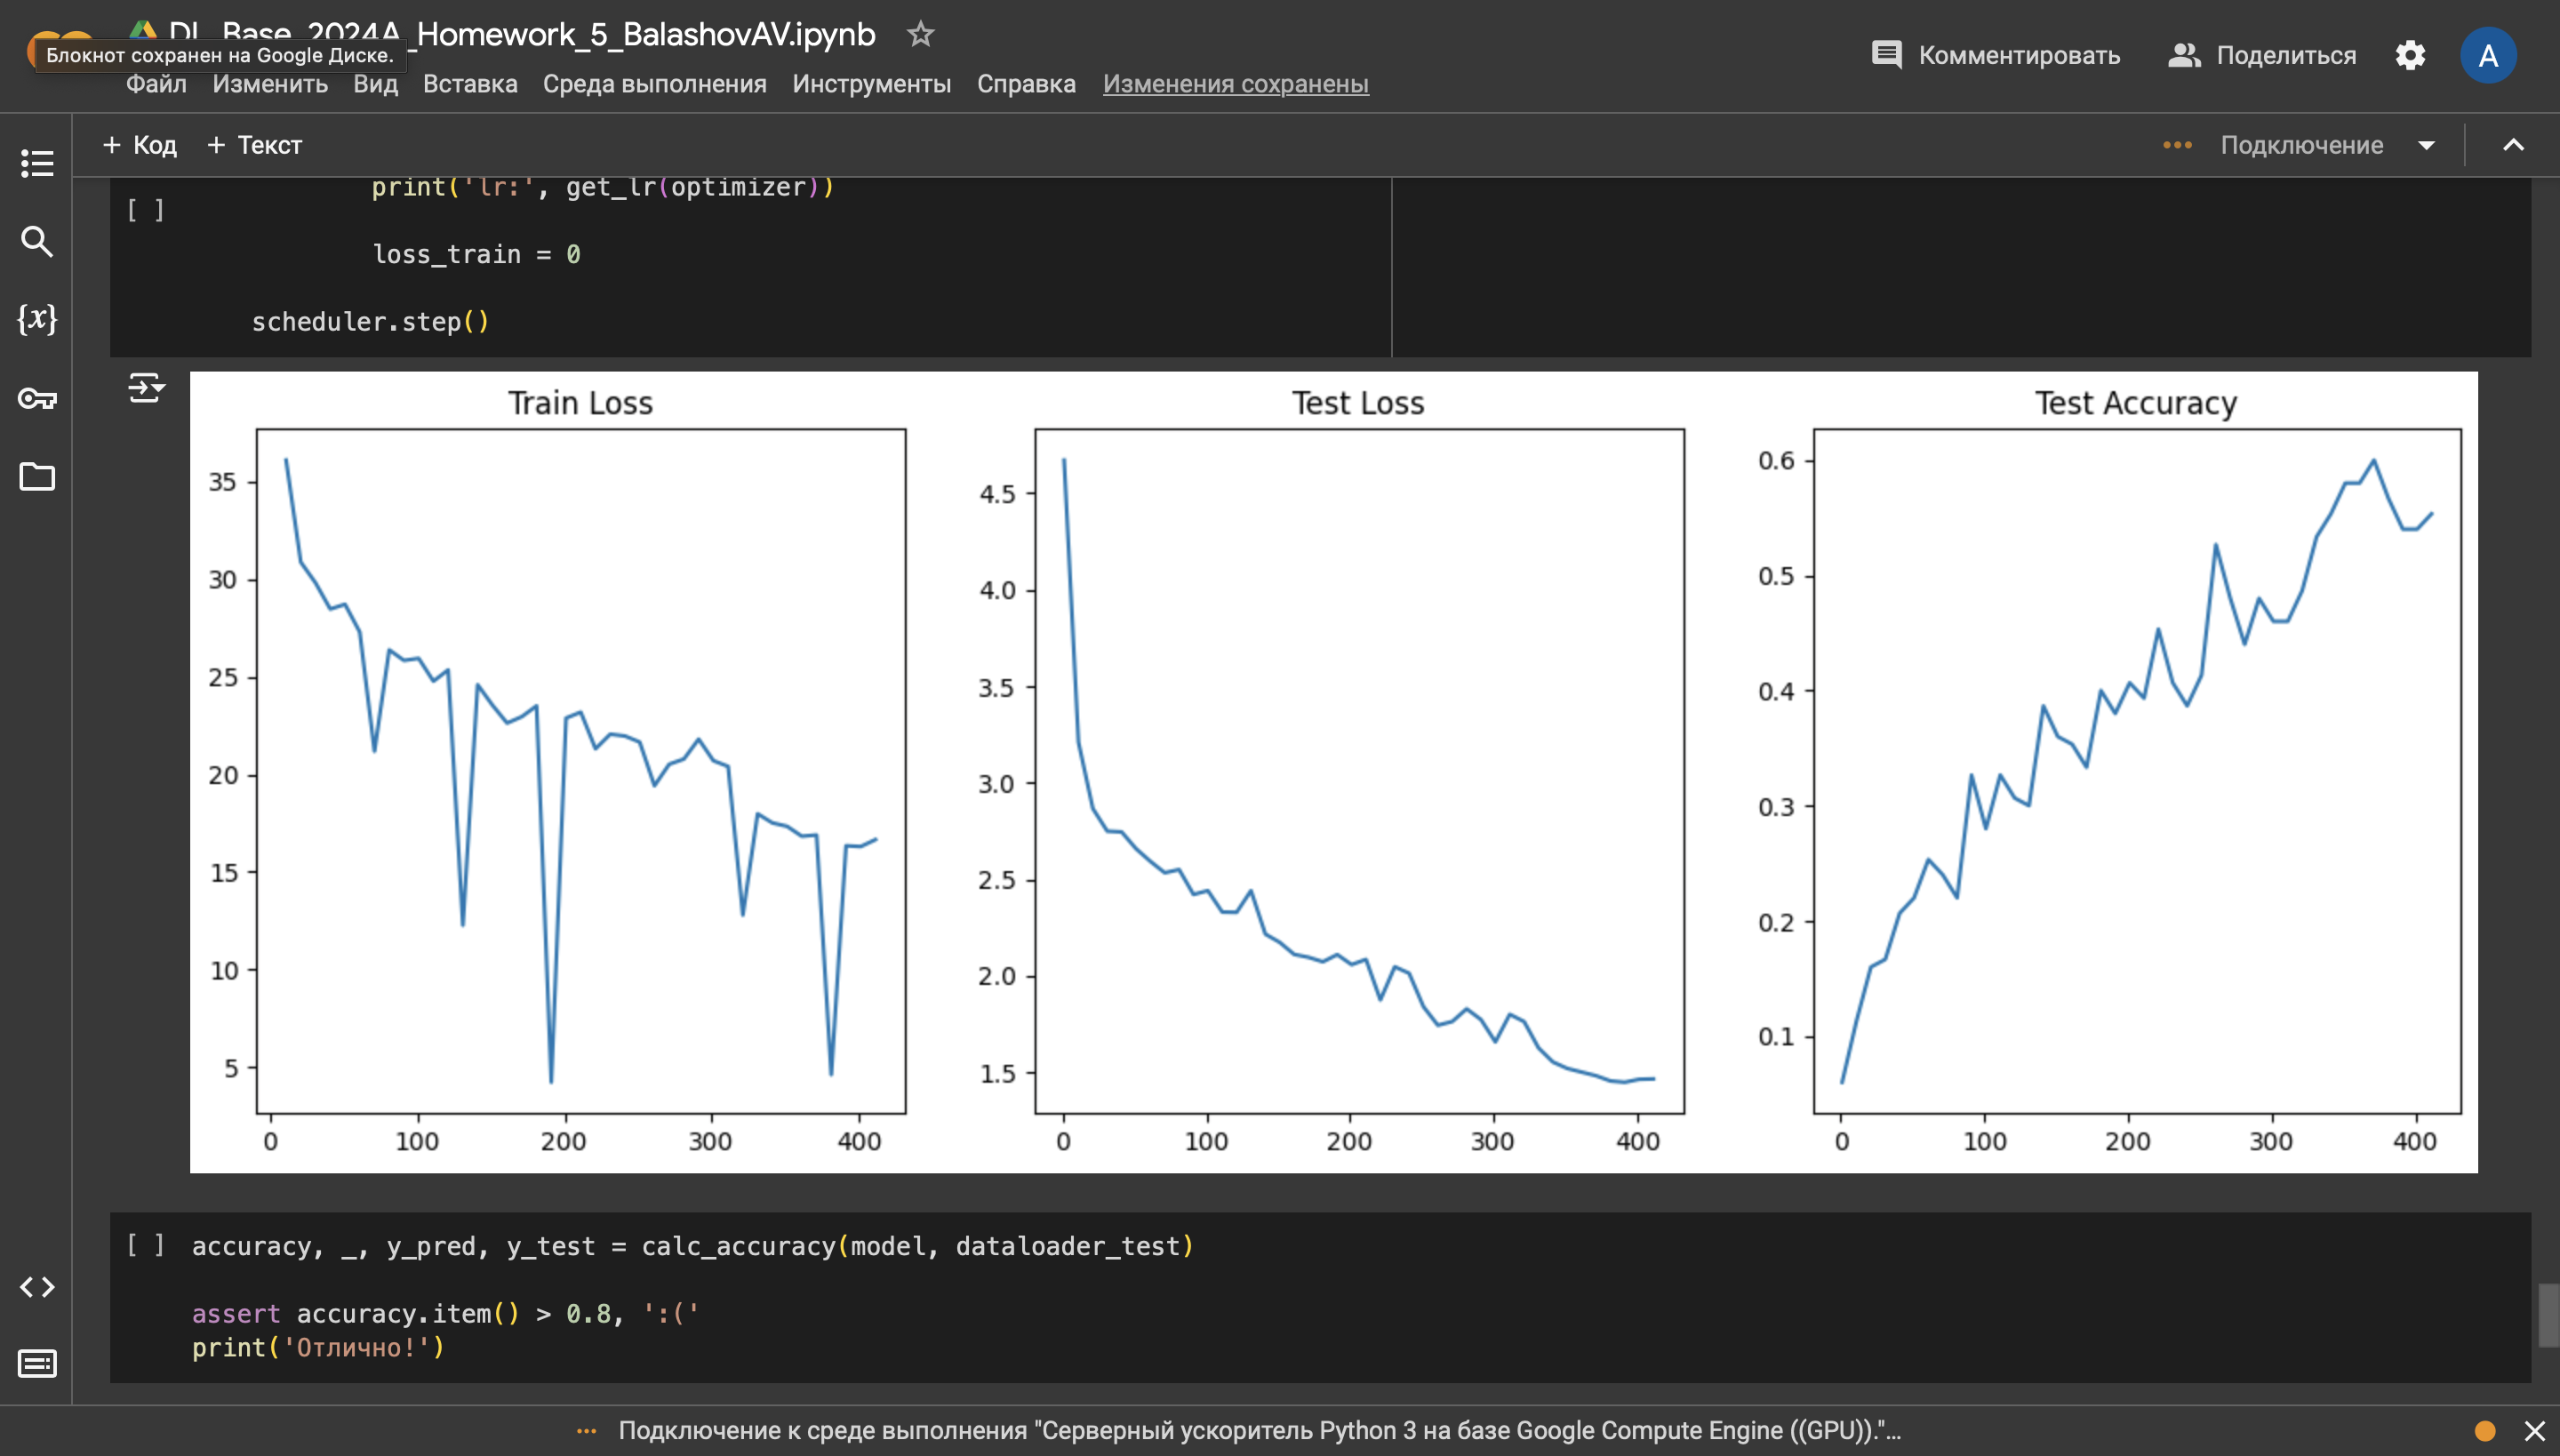

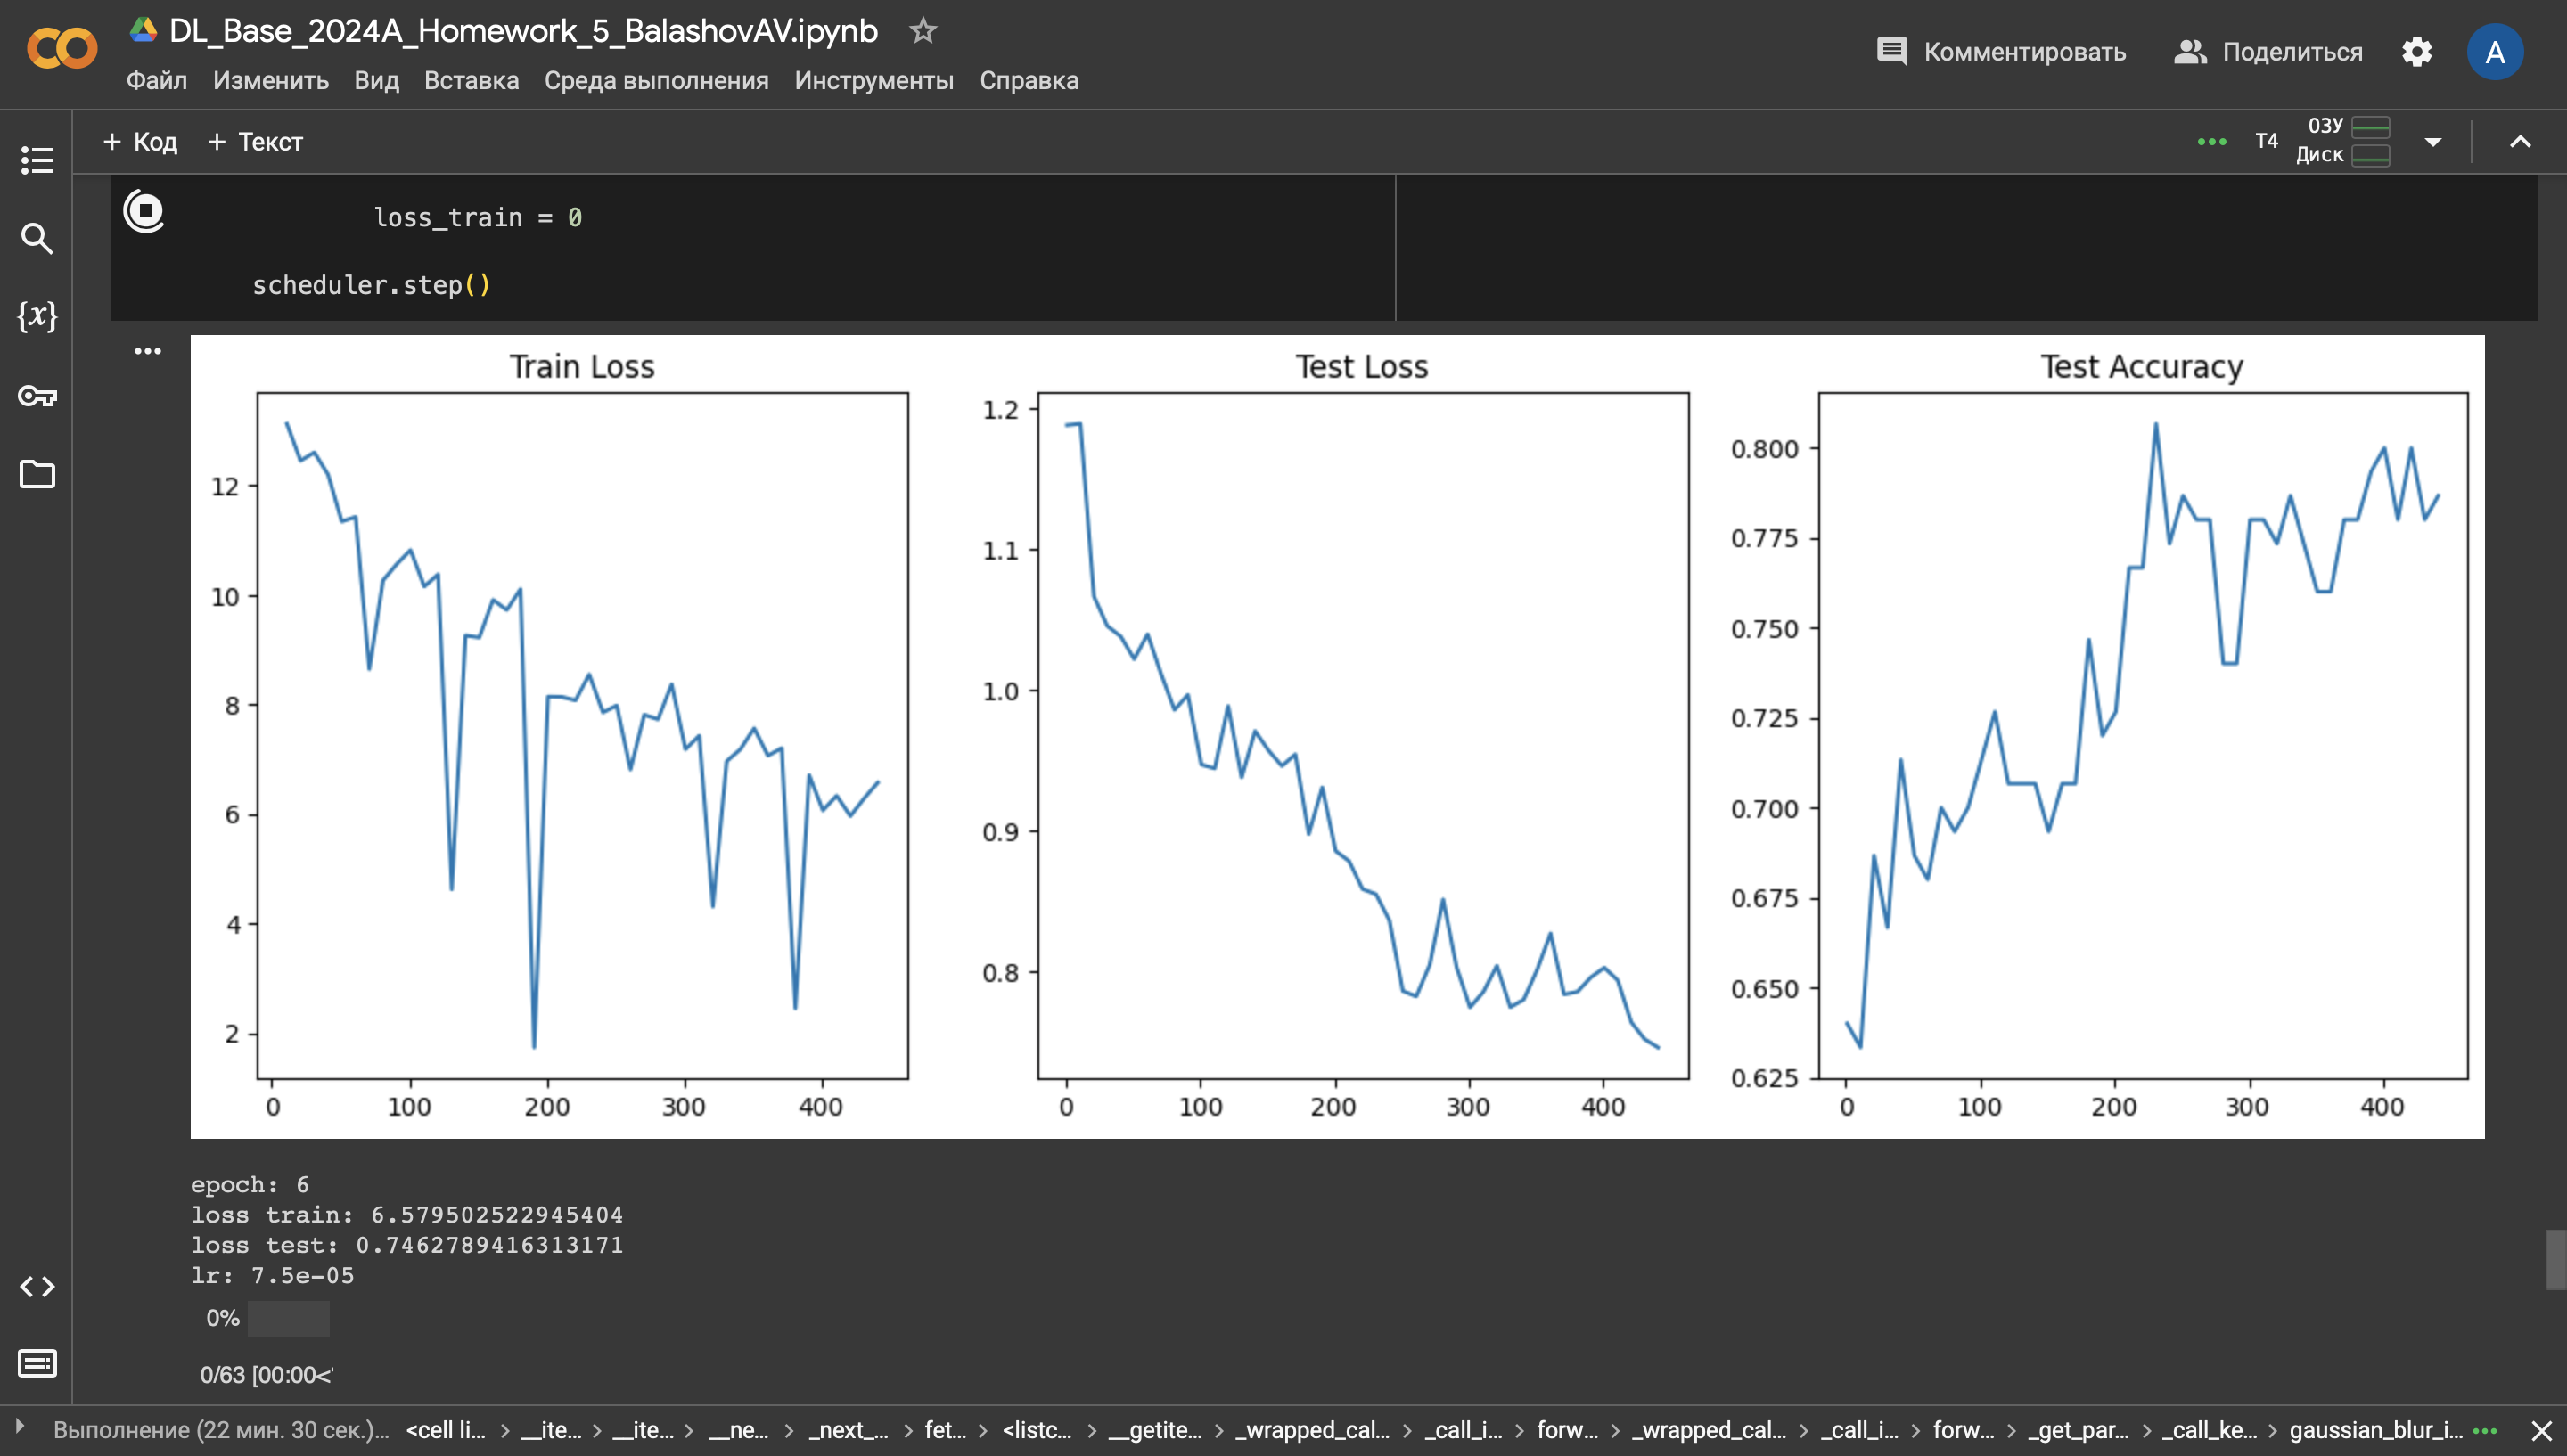

## <font color='MediumSeaGreen'> **Задание 5 [Bonus][2 балла]** </font>

Выбейте качество не менее 0.85 любым способом, используя сверточные нейросети

In [ ]:
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[2, 4, 6], gamma=0.5)

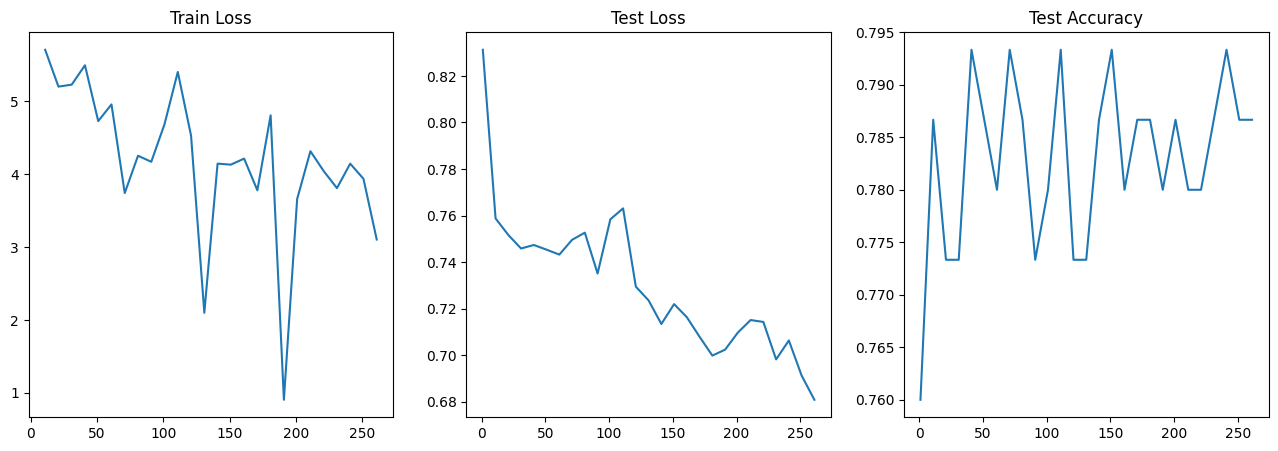


epoch: 4
loss train: 3.1047685146331787
loss test: 0.6808407306671143
lr: 2.5e-05


KeyboardInterrupt: 

In [ ]:
# your code here
cur_iter = 0
iter_list = []
test_accuracy_list = []
test_loss_list = []
train_loss_list = []
for epoch in range(n_epoch):
    loss_train = 0
    if accuracy.item() > 0.85:
        break
    for X, target in tqdm(dataloader_train, ncols=80):
        if accuracy.item() > 0.85:
            break
        cur_iter += 1
        X = X.cuda() #Когда отработает на CPU
        target = target.cuda() #Когда отработает на CPU
        optimizer.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, target)
        loss.backward()
        optimizer.step()

        loss_train += loss.item()

        if cur_iter % 10 == 1:
            accuracy, loss_test, _, _ = calc_accuracy(model, dataloader_test)
            iter_list.append(cur_iter)

            test_accuracy_list.append(accuracy)
            test_loss_list.append(loss_test)
            train_loss_list.append(loss_train)

            show_loss(iter_list, train_loss_list, test_loss_list, test_accuracy_list)

            print('\nepoch:', epoch)
            print('loss train:', loss_train)
            print('loss test:', loss_test)
            print('lr:', get_lr(optimizer))

            loss_train = 0

    scheduler.step()